<a href="https://colab.research.google.com/github/gvtsch/Udemy_TensorFlow_Certificate/blob/main/06_transfer_learning_with_TensorFlow_part_3_scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Part 3: Scaling up (Food Vision mini)

We've seen the power of transfer learning feature extraction and fine-tuning, now it's time to scale up to all of the classes in Food101 (101 total classes of food).

Our goal is to beat the original Food101 paper with 10% of the training (leveraging the power of deep learning).

Original Food101 paper: https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/

Our baseline to beat 50.76% accuracy across 101 classes.

In [1]:
# Check to see if we're using a GPU
!nvidia-smi

Tue Jun 28 20:32:34 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.59       Driver Version: 516.59       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   57C    P8    11W /  N/A |    414MiB /  6144MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper funtions

In previous notebooks, we've created a series of helper functions to do different tasks, let's download them.

In [2]:
import os

if not os.path.exists("helper_functions.py"):
  # !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
  !python -m wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [3]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

## 101 Food Classes: Working with less data

Our goal is to beat the original Food101 paper with 10% of the training data, so let's download it.

The data we're downloading comes from the original Food101 dataset but has been preprocessed using the image_data_notification notebook.

In [4]:
if not os.path.exists("101_food_classes_10_percent/"):
  # !wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
  !python -m wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
  unzip_data("101_food_classes_10_percent.zip")

In [5]:
train_dir = "101_food_classes_10_percent/train"
test_dir = "101_food_classes_10_percent/test"

In [6]:
# How many images/classes are there?
walk_through_dir("101_food_classes_10_percent")

There are 3 directories and 0 images in '101_food_classes_10_percent'.
There are 2 directories and 2 images in '101_food_classes_10_percent\saved_trained_model'.
There are 0 directories and 0 images in '101_food_classes_10_percent\saved_trained_model\assets'.
There are 0 directories and 2 images in '101_food_classes_10_percent\saved_trained_model\variables'.
There are 101 directories and 0 images in '101_food_classes_10_percent\test'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\apple_pie'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\baby_back_ribs'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\baklava'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\beef_carpaccio'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\beef_tartare'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\beet_salad'.
There are 0 directori

In [7]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE=(224, 224)

train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode="categorical",
    image_size=IMG_SIZE,
    batch_size=32
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode="categorical",
    image_size=IMG_SIZE,
    batch_size=32,
    shuffle=False # don't shuffle test data for prediction analysis
)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big dog model with transfer learning on 10% of 101 food classes

Here are the steps we're going to take:
* Create a model checkpoint callback
* Create a data augmentation layer to build data augmentation right into the model
* Build a headless (no top layers) Functional EfficientNetB0 backboned model (we'll create our own output layer)
* Compile our model
* Feature extract for 5 full passes (5 epochs on the train dataset and validate on 15% of the test data, to save epoch time)

In [8]:
# Create checkpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    save_weights_only=True,
    monitor="val_accuracy",
    save_best_only=True
)

In [9]:
# Create data augmentation layer to incorporate it right into the model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Setup data augmentation
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    # preprocessing.Rescale(1/255.) # Rescale inputs to 0 between, if not already rescaled like EfficientNet
], name="data_augmentation")

In [10]:
# Setup the base_model and freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs) # augment images (this only happens during training phase)
x = base_model(x, training=False) # put the base model in inference mode so weights which need to stay frozen, stay frozen
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x)
model = tf.keras.Model(inputs, outputs)

In [11]:
# Get summary
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_avg_pool_layer (Globa (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 101)               129381    
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [12]:
# Compile
model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [13]:
# Fit it for 5 epochs
initial_epochs = 5

history_all_classes_10_percent = model.fit(
    train_data_all_10_percent,
    epochs=initial_epochs,
    steps_per_epoch=len(train_data_all_10_percent),
    validation_data=test_data,
    validation_steps=int(0.15*len(test_data)), # validate on 15%
    callbacks=[
        create_tensorboard_callback(
            dir_name="transfer_learning",
            experiment_name="101_food_classes_10_percent"
        )
    ]
)

Saving TensorBoard log files to: transfer_learning/101_food_classes_10_percent/20220628-203243


c:\Users\gutsc\anaconda3\envs\udemy_tensorflow\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1/5
237/237 [==============================] - 110s 417ms/step - loss: 3.4880 - accuracy: 0.2438 - val_loss: 2.6186 - val_accuracy: 0.4235
Epoch 2/5
237/237 [==============================] - 75s 315ms/step - loss: 2.3523 - accuracy: 0.4593 - val_loss: 2.2033 - val_accuracy: 0.4799
Epoch 3/5
237/237 [==============================] - 70s 297ms/step - loss: 1.9734 - accuracy: 0.5295 - val_loss: 2.0410 - val_accuracy: 0.4897
Epoch 4/5
237/237 [==============================] - 62s 259ms/step - loss: 1.7562 - accuracy: 0.5737 - val_loss: 1.9614 - val_accuracy: 0.5026
Epoch 5/5
237/237 [==============================] - 62s 261ms/step - loss: 1.6009 - accuracy: 0.6063 - val_loss: 1.8946 - val_accuracy: 0.5109


In [14]:
# Evaluate on the whole test dataset
all_classes_10_percent_results = model.evaluate(test_data)
all_classes_10_percent_results

790/790 [==============================] - 68s 86ms/step - loss: 1.7104 - accuracy: 0.5540


[1.7103971242904663, 0.5539801716804504]

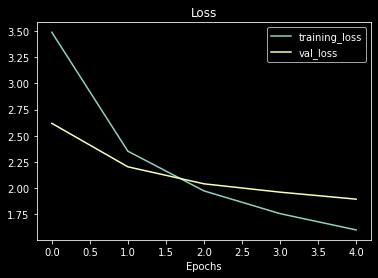

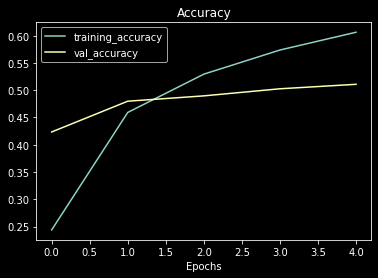

In [15]:
plot_loss_curves(history_all_classes_10_percent)

> 🤔 **Question:** What do these curves suggest? Hint: Ideally, the two curves should be pretty similar to each other, if not it may suggest that our model is overfitting (performing too well on the training data and not generalizing to unseen data).

## Fine-tuning

In [16]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze verey layer except the last 5
for layer in base_model.layers[:-5]:
    layer.trainable = False

In [17]:
# Recompile model with lower learning rate (it's typically best practive to lower the learning rate when fine-tuning).
model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(lr=0.0001), # lr lowered by 10x
    metrics=["accuracy"]
)

c:\Users\gutsc\anaconda3\envs\udemy_tensorflow\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [18]:
# What layers in the model are trainable?
for layer in model.layers:
    print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_avg_pool_layer True
output_layer True


In [19]:
# Check which layers are trainable in our base model?
for layer_number, layer in enumerate(model.layers[2].layers):
    print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

In [20]:
# Fine-tune for 5 more epochs
fine_tune_epochs = 10 # model has already done 5 epochs, this is the total number of epochs we're after (5 + 5)

# Fit the model
history_all_classes_10_percent_fine_tuned = model.fit(
    train_data_all_10_percent,
    epochs=fine_tune_epochs,
    steps_per_epoch=len(train_data_all_10_percent), # not neccessary according to a question in udemy. 
    validation_data=test_data,
    validation_steps=int(0.15*len(test_data)),
    initial_epoch=history_all_classes_10_percent.epoch[-1],
    callbacks=[
        create_tensorboard_callback(
            dir_name="transfer_learning",
            experiment_name="all_classes_10_percent_fine_tune"
        )
    ]
)

Saving TensorBoard log files to: transfer_learning/all_classes_10_percent_fine_tune/20220628-204013
Epoch 5/10
237/237 [==============================] - 70s 259ms/step - loss: 1.3494 - accuracy: 0.6481 - val_loss: 1.8508 - val_accuracy: 0.5188
Epoch 6/10
237/237 [==============================] - 55s 232ms/step - loss: 1.2295 - accuracy: 0.6792 - val_loss: 1.8212 - val_accuracy: 0.5299
Epoch 7/10
237/237 [==============================] - 53s 223ms/step - loss: 1.1545 - accuracy: 0.6915 - val_loss: 1.8649 - val_accuracy: 0.5188
Epoch 8/10
237/237 [==============================] - 49s 207ms/step - loss: 1.0904 - accuracy: 0.7135 - val_loss: 1.8673 - val_accuracy: 0.5188
Epoch 9/10
237/237 [==============================] - 51s 216ms/step - loss: 1.0185 - accuracy: 0.7265 - val_loss: 1.8393 - val_accuracy: 0.5252
Epoch 10/10
237/237 [==============================] - 48s 202ms/step - loss: 0.9722 - accuracy: 0.7402 - val_loss: 1.7944 - val_accuracy: 0.5400


In [21]:
# Evaluate on the whole test data
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results

790/790 [==============================] - 69s 87ms/step - loss: 1.6079 - accuracy: 0.5768


[1.6078609228134155, 0.5768316984176636]

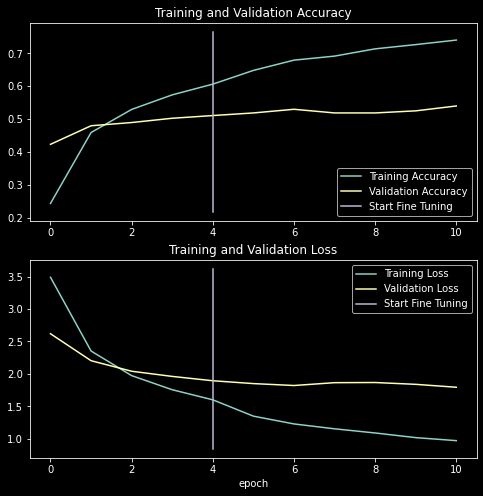

In [22]:
# Compare the historie of feature extraction model with fine-tuning model
compare_historys(
    original_history=history_all_classes_10_percent, 
    new_history=history_all_classes_10_percent_fine_tuned, 
    initial_epochs=5
)

## Saving and loading our model

To use our model in an external application, we'll save it and export somewhere

In [23]:
# Save our fine-tuned model
model.save("101_food_classes_10_percent/saved_trained_model/")

INFO:tensorflow:Assets written to: 101_food_classes_10_percent/saved_trained_model/assets


c:\Users\gutsc\anaconda3\envs\udemy_tensorflow\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [24]:
# Load and evaluate saved model
import tensorflow as tf
loaded_model = tf.keras.models.load_model("101_food_classes_10_percent/saved_trained_model/")

In [25]:
# Evaluate loaded model and compare performance to pre-saved model
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

790/790 [==============================] - 74s 89ms/step - loss: 1.6079 - accuracy: 0.5768


[1.6078609228134155, 0.5768316984176636]

In [26]:
# The results from our loaded_model (above) should be very similar to the results below
# all_classes_10_percent_fine_tuned_results

## Evaluating the performance of the big dog model across all different classes

Let's make some predictions, visualize them and then later find out which predictions were the "most" wrong.

In [27]:
import tensorflow as tf
import os

# Download pretrained mode (one that was prepared earlier, so all predictions are similar)
if not os.path.exists("07_efficientnetb0_fine_tuned_101_classes_mixed_precision.zip"):
    !python -m wget https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_fine_tuned_101_classes_mixed_precision.zip
if not os.path.exists("07_efficientnetb0_fine_tuned_101_classes_mixed_precision"):
    unzip_data("07_efficientnetb0_fine_tuned_101_classes_mixed_precision.zip")

In [28]:
# Load in saved model
# model = tf.keras.models.load_model("07_efficientnetb0_fine_tuned_101_classes_mixed_precision")

In [29]:
# Evaluate loaded model (the one we just downloaded on test data)
# results_downloaded_model = model.evaluate(test_data)
# results_downloaded_model

The model from dbourke isn't working in my case. That's why i am using my own loaded model for further work.

## Making predictions with our trained model

In [30]:
# Make predictions with model
preds_probs = loaded_model.predict(test_data, verbose=1) # set verborsity to see how long is left

790/790 [==============================] - 66s 79ms/step


In [31]:
len(test_data)

790

In [32]:
# How many predictions are there?
len(preds_probs)

25250

In [33]:
# What's the shape of our predictions?
preds_probs.shape

(25250, 101)

In [34]:
# Let's see what the first 10 predictions look like
preds_probs[:10]

array([[5.90080440e-01, 1.44795646e-04, 5.02662994e-02, ...,
        4.15184440e-05, 5.95019839e-04, 1.06070787e-01],
       [9.26912248e-01, 3.08654080e-08, 2.28566956e-03, ...,
        2.77120620e-03, 3.26030289e-07, 5.00603892e-06],
       [3.09688151e-01, 3.90412263e-03, 4.90405224e-03, ...,
        3.19043698e-04, 1.49645971e-03, 4.60208952e-03],
       ...,
       [3.39643747e-01, 1.31043282e-06, 3.22040776e-03, ...,
        1.84754450e-02, 8.05906602e-05, 3.55551601e-05],
       [1.18889466e-01, 9.31276998e-04, 3.77007835e-02, ...,
        2.96295417e-04, 1.01215628e-04, 3.51348164e-04],
       [6.56943798e-01, 7.25611017e-07, 3.01430206e-04, ...,
        1.61768291e-02, 6.10946790e-06, 2.27605132e-03]], dtype=float32)

In [35]:
# What does the first prediction probability array look like?
preds_probs[0], len(preds_probs[0]), sum(preds_probs[0])

(array([5.9008044e-01, 1.4479565e-04, 5.0266299e-02, 6.8267321e-09,
        1.2715163e-06, 4.7178091e-06, 2.9949138e-05, 1.6308459e-05,
        1.1659621e-02, 2.4068526e-04, 2.3779578e-06, 1.1491846e-05,
        2.0841549e-03, 1.2646402e-06, 1.1536038e-02, 4.0370945e-04,
        2.0330959e-05, 5.0765608e-04, 1.9733433e-04, 7.0503411e-06,
        5.3744439e-05, 3.6342219e-05, 8.6330262e-04, 3.3802094e-04,
        4.9442245e-04, 8.8656181e-04, 1.3739576e-04, 1.0296292e-05,
        4.2976454e-02, 3.0540517e-03, 3.5393914e-06, 3.5274948e-04,
        1.5472533e-03, 1.8507610e-07, 1.8626630e-03, 7.3551596e-06,
        4.4281631e-05, 7.1842055e-04, 6.9647552e-03, 3.5393325e-05,
        3.2489770e-04, 1.2272123e-03, 9.3266339e-04, 3.0877245e-06,
        2.1798083e-05, 7.0822607e-05, 4.9380801e-04, 1.5821095e-04,
        4.2692778e-07, 3.5140727e-02, 2.5608944e-04, 5.7683457e-05,
        2.3911251e-02, 5.4815384e-03, 6.3777348e-05, 4.1186376e-03,
        1.5489652e-02, 3.2515700e-03, 3.5957086e

Our model outputs a prediction probability array (with N number of variables, where N is the number of classes) for each sample passed to the predict method

In [36]:
# We get one prediction probability per class (in our case there's 101 prediction probabilities)
print(f"Number of prediction probabilities for sample 0: {len(preds_probs[0])}")
print(f"What prediction probability sample 0 looks like: \n{preds_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {tf.argmax(preds_probs[0])}")

Number of prediction probabilities for sample 0: 101
What prediction probability sample 0 looks like: 
[5.9008044e-01 1.4479565e-04 5.0266299e-02 6.8267321e-09 1.2715163e-06
 4.7178091e-06 2.9949138e-05 1.6308459e-05 1.1659621e-02 2.4068526e-04
 2.3779578e-06 1.1491846e-05 2.0841549e-03 1.2646402e-06 1.1536038e-02
 4.0370945e-04 2.0330959e-05 5.0765608e-04 1.9733433e-04 7.0503411e-06
 5.3744439e-05 3.6342219e-05 8.6330262e-04 3.3802094e-04 4.9442245e-04
 8.8656181e-04 1.3739576e-04 1.0296292e-05 4.2976454e-02 3.0540517e-03
 3.5393914e-06 3.5274948e-04 1.5472533e-03 1.8507610e-07 1.8626630e-03
 7.3551596e-06 4.4281631e-05 7.1842055e-04 6.9647552e-03 3.5393325e-05
 3.2489770e-04 1.2272123e-03 9.3266339e-04 3.0877245e-06 2.1798083e-05
 7.0822607e-05 4.9380801e-04 1.5821095e-04 4.2692778e-07 3.5140727e-02
 2.5608944e-04 5.7683457e-05 2.3911251e-02 5.4815384e-03 6.3777348e-05
 4.1186376e-03 1.5489652e-02 3.2515700e-03 3.5957086e-03 4.8384321e-05
 1.2370000e-06 5.0407409e-04 2.9040815e-02 2.

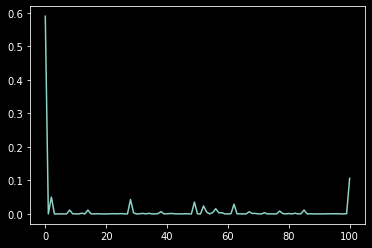

In [37]:
# Visualize the probabilities
matplotlib.pyplot.plot(preds_probs[0])

In [38]:
test_data.class_names[tf.argmax(preds_probs[0])]

'apple_pie'

In [39]:
# Get the pred classes of each label
pred_classes = preds_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([ 0,  0,  0,  8,  0, 78, 29, 46,  9,  0], dtype=int64)

In [40]:
# How many pred classes do we have?
len(pred_classes)

25250

Now we've got a predictions array of all of our model's predictions, to evaluate them, we need to compare them to the original test dataset labels.

In [41]:
test_data, len(test_data)

(<BatchDataset shapes: ((None, 224, 224, 3), (None, 101)), types: (tf.float32, tf.float32)>,
 790)

In [42]:
# To get our test labels we need to unravel our test_data BatchDataset
y_labels = []
for images, labels in test_data.unbatch():
    y_labels.append(labels.numpy().argmax()) # currently test labels look like [0, 0, 0, 1, ... 0, 0], we want the index value where the "1" occurs
y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [43]:
# How many y_labels are there?
len(y_labels)

25250

## Evaluating our model's predictions

One way to check that our model's predictions array is in the same order as our test labels array is to find the accuracy score.

In [44]:
loaded_model_results

[1.6078609228134155, 0.5768316984176636]

In [45]:
# Let's try scikit-learn's accuracy score function and see what it comes up with
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_true=y_labels, y_pred=pred_classes)
sklearn_accuracy

0.5768316831683168

In [46]:
# Does this metric come close to our model's evaluate results
import numpy as np
np.isclose(loaded_model_results[1], sklearn_accuracy)

True

## Let's get visual: making a confusion matrix

In [48]:
from helper_functions import make_confusion_matrix

In [53]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# We need to make some changes to our make_confusion_matrix function to ensure x-labels print vertically

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  """ Changed plot(x-labels veritcally) """
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [ ]:
# Get a list of class_names
class_names = test_data.class_names
make_confusion_matrix(y_true=y_labels, 
    y_pred=pred_classes, 
    classes=class_names, 
    figsize=(100,100), 
    text_size=10,
    savefig=True)

## Let's keep the evaluation train going, time for a classification report

scikit-learn has a helpful function for acquiring many different classification metrics per class (e.g. precision, recall and F1) called [classification_report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html), let's try it out.

In [56]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels, 
    y_pred=pred_classes))

              precision    recall  f1-score   support

           0       0.32      0.20      0.24       250
           1       0.48      0.72      0.58       250
           2       0.66      0.57      0.61       250
           3       0.84      0.47      0.60       250
           4       0.50      0.46      0.48       250
           5       0.39      0.38      0.39       250
           6       0.83      0.66      0.73       250
           7       0.84      0.70      0.77       250
           8       0.23      0.62      0.34       250
           9       0.35      0.67      0.46       250
          10       0.45      0.46      0.45       250
          11       0.69      0.60      0.64       250
          12       0.62      0.60      0.61       250
          13       0.62      0.46      0.53       250
          14       0.48      0.55      0.51       250
          15       0.43      0.27      0.33       250
          16       0.72      0.44      0.55       250
          17       0.39    

The numbers above give a great class-by-class evaluation of our model's predictions but with so many classes, they're quite hard to understand. 

How about we create a visualization to get a better understanding?

In [58]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'precision': 0.3181818181818182,
  'recall': 0.196,
  'f1-score': 0.24257425742574257,
  'support': 250},
 '1': {'precision': 0.4826666666666667,
  'recall': 0.724,
  'f1-score': 0.5792,
  'support': 250},
 '2': {'precision': 0.6574074074074074,
  'recall': 0.568,
  'f1-score': 0.6094420600858369,
  'support': 250},
 '3': {'precision': 0.8357142857142857,
  'recall': 0.468,
  'f1-score': 0.6,
  'support': 250},
 '4': {'precision': 0.4978165938864629,
  'recall': 0.456,
  'f1-score': 0.4759916492693111,
  'support': 250},
 '5': {'precision': 0.38866396761133604,
  'recall': 0.384,
  'f1-score': 0.38631790744466804,
  'support': 250},
 '6': {'precision': 0.8291457286432161,
  'recall': 0.66,
  'f1-score': 0.734966592427617,
  'support': 250},
 '7': {'precision': 0.8421052631578947,
  'recall': 0.704,
  'f1-score': 0.7668845315904139,
  'support': 250},
 '8': {'precision': 0.23168908819133036,
  'recall': 0.62,
  'f1-score': 0.3373231773667029,
  'support': 250},
 '9': {'precision'

In [63]:
classification_report_dict["42"]

{'precision': 0.4779116465863454,
 'recall': 0.476,
 'f1-score': 0.4769539078156313,
 'support': 250}

In [62]:
class_names[42]

'french_toast'

Let's plot all of our classes F1-scores...

In [69]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report dictionary items
for k, v in classification_report_dict.items():
    if k == "accuracy": # stop once we get to accuracy key
        break
    else: # Add class names and f1-scores to new dictionary
        class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'apple_pie': 0.24257425742574257,
 'baby_back_ribs': 0.5792,
 'baklava': 0.6094420600858369,
 'beef_carpaccio': 0.6,
 'beef_tartare': 0.4759916492693111,
 'beet_salad': 0.38631790744466804,
 'beignets': 0.734966592427617,
 'bibimbap': 0.7668845315904139,
 'bread_pudding': 0.3373231773667029,
 'breakfast_burrito': 0.46344827586206894,
 'bruschetta': 0.45364891518737677,
 'caesar_salad': 0.6425531914893616,
 'cannoli': 0.6085192697768763,
 'caprese_salad': 0.5275229357798165,
 'carrot_cake': 0.5111111111111111,
 'ceviche': 0.3333333333333333,
 'cheese_plate': 0.5481481481481482,
 'cheesecake': 0.4030710172744722,
 'chicken_curry': 0.4755244755244755,
 'chicken_quesadilla': 0.6108597285067874,
 'chicken_wings': 0.7160000000000001,
 'chocolate_cake': 0.5321100917431192,
 'chocolate_mousse': 0.34755134281200634,
 'churros': 0.7042801556420233,
 'clam_chowder': 0.6666666666666665,
 'club_sandwich': 0.6785009861932938,
 'crab_cakes': 0.3644444444444444,
 'creme_brulee': 0.7228915662650602,
 

In [71]:
# Turn f1-scores into datafram for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_names": list(class_f1_scores.keys()),
    "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores

,class_names,f1-score
33,edamame,0.953125
63,macarons,0.852814
75,pho,0.832700
86,sashimi,0.822394
51,guacamole,0.819923
...,...,...
37,filet_mignon,0.307255
87,scallops,0.305085
93,steak,0.302913
99,tuna_tartare,0.283843
